# Model Benchmarking 

## Data Balance Examination and Splitting

### Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings 
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/processed/main_data_processed2.csv')

### Controlling Data Balance

In [3]:
X = df.drop('Exited', axis=1)
y = df['Exited']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,       
    random_state=42,
    stratify=y
)

In [5]:
negatives = y_train.value_counts()[0]
positives = y_train.value_counts()[1]

print(f"Negative: {negatives}")
print(f"Positive: {positives}")

Negative: 6370
Positive: 1630


**Key Insights:**
*    As we see at the last output, there is a unbalanced distribution for the target column.

### Intervention in Data Balance

In [6]:
scale_pos_weight_ratio = negatives / positives
print(f"Scale Pos Weight Ratio: {scale_pos_weight_ratio}")

Scale Pos Weight Ratio: 3.9079754601226995


**Key Insights:**
*    We need the SPC ratio to highlight rare classes of unbalanced dataset. 
*    To do this, we set the ratio of negative to positive values ​​to a variable called "scale_pos_weight_ratio".

## Model Comparison

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [8]:
models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', 
                                              random_state=42, 
                                              max_iter=1000),
    
    "Decision Tree": DecisionTreeClassifier(class_weight='balanced', 
                                            random_state=42),
    
    "Random Forest": RandomForestClassifier(class_weight='balanced', 
                                            random_state=42),
    
    "XGBoost": XGBClassifier(scale_pos_weight=scale_pos_weight_ratio, 
                             eval_metric='logloss', 
                             random_state=42, 
                             use_label_encoder=False),
    
    "LightGBM": LGBMClassifier(scale_pos_weight = scale_pos_weight_ratio, 
                               random_state=42, 
                               verbose=-1)
}

**Key Insights:**
*    LogisticRegression, DecisionTreeClassifier and RandomForestClassifier don't need to SCP ratio. 'class_weight' parameter is enough to make balance.
*    XGBClassifier and LGBMClassifier need to scale_pos_weight parameter to make balance for unbalanced target.

In [9]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
import numpy as np

# Sonuçları tutacak liste
results = []
names = []

print("Model Performances (F1-Score ve ROC-AUC):")
print("-" * 50)

for name, model in models.items():
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_results_f1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    cv_results_auc = cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    results.append(cv_results_f1)
    names.append(name)
    
    print(f"{name}:")
    print(f"  F1 Score: {cv_results_f1.mean():.4f} (+/- {cv_results_f1.std():.4f})")
    print(f"  ROC-AUC : {cv_results_auc.mean():.4f}")
    print("-" * 50)

Model Performances (F1-Score ve ROC-AUC):
--------------------------------------------------
Logistic Regression:
  F1 Score: 0.4905 (+/- 0.0233)
  ROC-AUC : 0.7668
--------------------------------------------------
Decision Tree:
  F1 Score: 0.4923 (+/- 0.0150)
  ROC-AUC : 0.6803
--------------------------------------------------
Random Forest:
  F1 Score: 0.5567 (+/- 0.0334)
  ROC-AUC : 0.8485
--------------------------------------------------
XGBoost:
  F1 Score: 0.5899 (+/- 0.0299)
  ROC-AUC : 0.8356
--------------------------------------------------
LightGBM:
  F1 Score: 0.6079 (+/- 0.0183)
  ROC-AUC : 0.8551
--------------------------------------------------


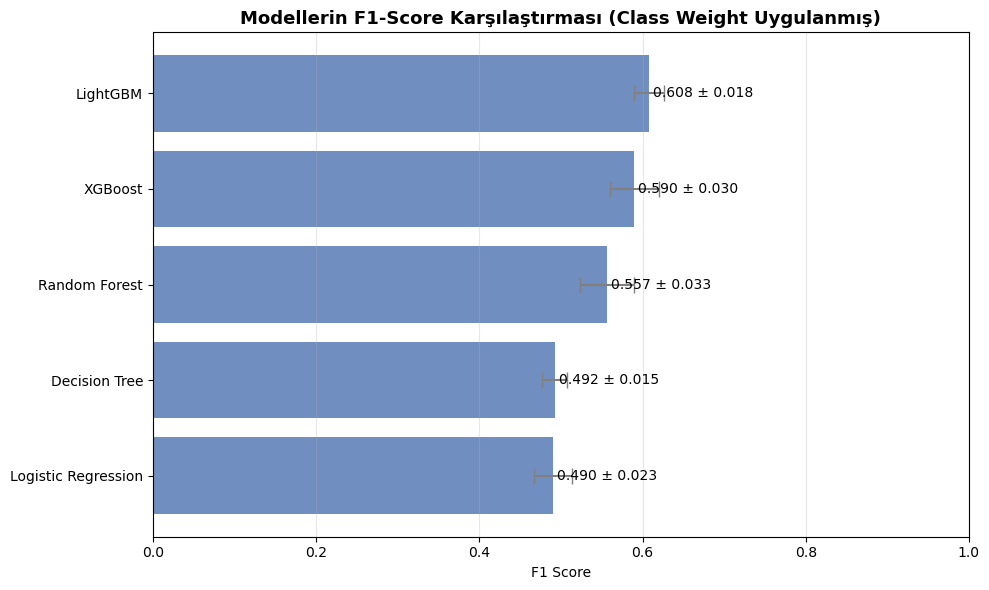

In [10]:
import numpy as np
import matplotlib.pyplot as plt

means = [np.mean(r) for r in results]
stds = [np.std(r) for r in results]

plt.figure(figsize=(10, 6))
plt.barh(names, means, xerr=stds, color='#4C72B0', alpha=0.8, ecolor='gray', capsize=6)

for i, (m, s) in enumerate(zip(means, stds)):
    plt.text(m + 0.005, i, f"{m:.3f} ± {s:.3f}", va='center', fontsize=10)

plt.title('Modellerin F1-Score Karşılaştırması (Class Weight Uygulanmış)', fontsize=13, fontweight='bold')
plt.xlabel('F1 Score')
plt.xlim(0, 1)
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**Key Insights:**
*    As we can see on plot and model performances output, LightGBM has highest F1 Score.
*    We will continue with LightGBM during hyperparameter adjustments.